In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Mounted at /content/drive
/content


In [2]:
!ls
%cd drive/MyDrive/DA/assignment1
!pwd

drive  sample_data
/content/drive/MyDrive/DA/assignment1
/content/drive/MyDrive/DA/assignment1


In [3]:
!pip install scikit-plot

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from math import pi
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, normalize, MinMaxScaler
from sklearn.ensemble import IsolationForest
import seaborn as sn
import math
import collections
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier

KNN can suffer from skewed class distributions. For example, if a certain class is very frequent in the training set, it will tend to dominate the majority voting of the new example (large number = more common).

#**Load Processed Dataset**

In [6]:
df_data_org = pd.read_csv('binarized_earthquake_42.csv', na_values=np.NaN)
print(df_data_org.shape)
display(df_data_org.head())
display(df_data_org.info())
display(df_data_org.describe())

(50480, 5)


,year,month,mw,depth (km),geo_dist
0,25,1.0,1,0.0,5240.055003
1,26,5.0,1,33.0,5565.618141
2,26,5.0,1,80.0,6652.904246
3,50,1.0,1,0.0,5097.739358
4,110,1.0,1,0.0,5332.611383


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50480 entries, 0 to 50479
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        50480 non-null  int64  
 1   month       50480 non-null  float64
 2   mw          50480 non-null  int64  
 3   depth (km)  50480 non-null  float64
 4   geo_dist    50480 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 1.9 MB


None

,year,month,mw,depth (km),geo_dist
count,50480.000000,50480.000000,50480.000000,50480.000000,50480.000000
mean,1993.131517,6.320345,0.787619,45.334145,5816.092705
std,34.071987,3.647405,0.408997,55.431256,638.647131
min,25.000000,1.000000,0.000000,0.000000,2432.055157
25%,1988.000000,3.000000,1.000000,10.000000,5266.089958
50%,2000.000000,6.000000,1.000000,33.000000,5873.625518
75%,2005.000000,10.000000,1.000000,53.400000,6224.439076
max,2019.000000,12.000000,1.000000,831.200000,11287.684246


#**Standardize the Data**  
StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation. It makes the mean of the distribution 0. About 68% of the values will lie be between -1 and 1.  
  
I find standardization better than min-max normalization as min-max scaling is very sensitive to outliers and the variance of the scaled data can reduce significantly as the divisor is the difference between the max and min values of the feature which can be very large when outliers are present.

In [7]:
X = df_data_org.drop(['mw'], axis=1).values
Y = df_data_org.mw.values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(X.shape)
print(Y.shape)
print("Total",Counter(Y))

Xs_train, Xs_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.20, random_state=1)
print("Train",Counter(Y_train))
print("Test",Counter(Y_test))

(50480, 4)
(50480,)
Total Counter({1: 39759, 0: 10721})
Train Counter({1: 31868, 0: 8516})
Test Counter({1: 7891, 0: 2205})


#**Evaluation Metrics**  
  
**Accuracy** : It is the percentage of number of correct predictions made by the model. But in the case of imbalanced / skewed dataset (as here) accuracy is no longer a proper measure, since it does not distinguish between the numbers of correctly classified examples of different classes. Instead, we can use other measures in this case, given below.

**Precision** : Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive. Precision is a good measure to determine, when there is a high cost associated with False Positives.  
P = TP / (TP + FP)  
  
**Recall** : Recall actually calculates how many of the Actual Positives our model captured correctly. Recall is a good measure to determine, when there is a high cost associated with False Negatives.  
R = TP / (TP + FN)  

**F1 Score** : F1 Score is used if we need to seek a balance between Precision and Recall and there is an uneven class distribution (large number of Actual Negatives). Accuracy can be largely contributed by a large number of True Negatives which in most business circumstances, we do not focus on much whereas False Negatives and False Positives usually have business costs (tangible & intangible) thus F1 Score might be a better measure to use .  
F1 = 2 x (P x R) / (P + R)  
  
**ROC AUC Score** : ROC (Receiver Operating Characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. AUC stands for "Area under the ROC Curve." It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting correct classes.

#**KNN Classifier**  
We use standardized data for KNN classification as KNN calculates the distance between the features of the rows. Hence, if the scale of the features vary (eg: meters and kilometers), KNN will not be able to find accurate neighbours.

##Hyperparameter Tuning for K  
Fitting KNN classifier for various values of K with weighted distance to find the K that gives the best AUC-ROC score

In [26]:
for k in range(7,26,2):
    neigh = KNeighborsClassifier(n_neighbors=k, weights='distance')
    neigh.fit(Xs_train, Y_train)
    Y_pred = neigh.predict(Xs_test)
    target_names = ['class 0', 'class 1']
    print("***** K =",k,"*****")
    print(classification_report(Y_test, Y_pred, target_names=target_names))
    print("ROC AUC score:",roc_auc_score(Y_test, neigh.predict_proba(Xs_test)[:,1]))
    print("\n")

***** K = 7 *****
              precision    recall  f1-score   support

     class 0       0.41      0.25      0.31      2205
     class 1       0.81      0.90      0.85      7891

    accuracy                           0.76     10096
   macro avg       0.61      0.57      0.58     10096
weighted avg       0.72      0.76      0.73     10096

ROC AUC score: 0.672733281205863


***** K = 9 *****
              precision    recall  f1-score   support

     class 0       0.42      0.23      0.30      2205
     class 1       0.81      0.91      0.86      7891

    accuracy                           0.76     10096
   macro avg       0.62      0.57      0.58     10096
weighted avg       0.72      0.76      0.74     10096

ROC AUC score: 0.6804164795221515


***** K = 11 *****
              precision    recall  f1-score   support

     class 0       0.43      0.22      0.29      2205
     class 1       0.81      0.92      0.86      7891

    accuracy                           0.76     10096
  

We see that, the higher the K, the better is the AUC-ROC scores. We choose K=25.

              precision    recall  f1-score   support

     class 0       0.45      0.17      0.25      2205
     class 1       0.80      0.94      0.87      7891

    accuracy                           0.77     10096
   macro avg       0.63      0.56      0.56     10096
weighted avg       0.73      0.77      0.73     10096

ROC AUC score: 0.697022096127768


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


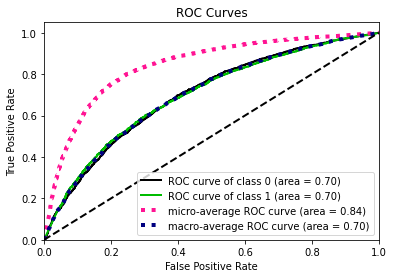

In [27]:
neigh = KNeighborsClassifier(n_neighbors=25, weights='distance')
neigh.fit(Xs_train, Y_train)
Y_pred = neigh.predict(Xs_test)
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Y_pred, target_names=target_names))
print("ROC AUC score:",roc_auc_score(Y_test, neigh.predict_proba(Xs_test)[:,1]))
Y_prob = neigh.predict_proba(Xs_test)
skplt.metrics.plot_roc_curve(Y_test, Y_prob)
plt.show()

#**Decision Tree Classifier**  
  
Decision trees classification is not impacted by the outliers in the data or data transformations like standardization and normalization, as long as you preserve order. The reason why it happens is because how usual impurity functions works. The data is split using scores which are calculated using the homogeneity of the resultant data points.

##Decision Tree Classification on Non-Standardized Data

In [28]:
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(X, Y, test_size=0.20, random_state=2, stratify=Y)
print("Train",len(Yt_train),Counter(Yt_train))
print("Test",len(Yt_test),Counter(Yt_test))

Train 40384 Counter({1: 31807, 0: 8577})
Test 10096 Counter({1: 7952, 0: 2144})


##Hyperparameter tuning for Minimum Samples to Split  
This parameter also affects the depth of the tree. The higher the parameter value, lesser would be the depth of the tree.

In [29]:
for m in [2,10,50,100,250,500,1000]:
    dtree = DecisionTreeClassifier(min_samples_split=m)
    dtree.fit(Xt_train, Yt_train)
    Yt_pred = dtree.predict(Xt_test)
    target_names = ['class 0', 'class 1']
    print("***** Min samples for splitting :",m,"*****")
    print(classification_report(Yt_test, Yt_pred, target_names=target_names))
    print("ROC AUC score:",roc_auc_score(Yt_test, dtree.predict_proba(Xt_test)[:,1]))
    print('\n')

***** Min samples for splitting : 2 *****
              precision    recall  f1-score   support

     class 0       0.34      0.34      0.34      2144
     class 1       0.82      0.82      0.82      7952

    accuracy                           0.72     10096
   macro avg       0.58      0.58      0.58     10096
weighted avg       0.72      0.72      0.72     10096

ROC AUC score: 0.5837847162264633


***** Min samples for splitting : 10 *****
              precision    recall  f1-score   support

     class 0       0.35      0.34      0.34      2144
     class 1       0.82      0.82      0.82      7952

    accuracy                           0.72     10096
   macro avg       0.58      0.58      0.58     10096
weighted avg       0.72      0.72      0.72     10096

ROC AUC score: 0.6258711316405897


***** Min samples for splitting : 50 *****
              precision    recall  f1-score   support

     class 0       0.42      0.27      0.33      2144
     class 1       0.82      0.90    

We obtain highest AUC-ROC score at value 250.

##Finding Important Features

The relative rank (i.e. depth) of a feature used as a decision node in a tree can be used to assess the relative importance of that feature with respect to the predictability of the target variable. Features used at the top of the tree contribute to the final prediction decision of a larger fraction of the input samples. The expected fraction of the samples they contribute to can thus be used as an estimate of the relative importance of the features.

              precision    recall  f1-score   support

     class 0       0.50      0.19      0.28      2144
     class 1       0.81      0.95      0.88      7952

    accuracy                           0.79     10096
   macro avg       0.66      0.57      0.58     10096
weighted avg       0.75      0.79      0.75     10096

ROC AUC score: 0.7274093194896993


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


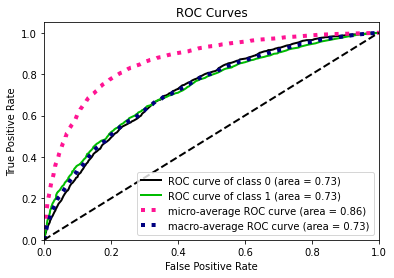


Feature Importances : {'year': 0.47, 'geo_dist': 0.27, 'depth (km)': 0.2, 'month': 0.06}


In [30]:
dtree = DecisionTreeClassifier(min_samples_split=250)
dtree.fit(Xt_train, Yt_train)
Yt_pred = dtree.predict(Xt_test)
target_names = ['class 0', 'class 1']
print(classification_report(Yt_test, Yt_pred, target_names=target_names))
print("ROC AUC score:",roc_auc_score(Yt_test, dtree.predict_proba(Xt_test)[:,1]))
Yt_prob = dtree.predict_proba(Xt_test)
skplt.metrics.plot_roc_curve(Yt_test, Yt_prob)
plt.show()
feature_importances = [round(f,2) for f in dtree.feature_importances_]
feature_importances = dict(zip(df_data_org.drop(['mw'], axis=1).columns,feature_importances))
feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))
print("\nFeature Importances :",feature_importances)

##Decision Tree Classification on Standardized Data

              precision    recall  f1-score   support

     class 0       0.55      0.19      0.28      2205
     class 1       0.81      0.96      0.88      7891

    accuracy                           0.79     10096
   macro avg       0.68      0.57      0.58     10096
weighted avg       0.75      0.79      0.75     10096

ROC AUC score: 0.7295965638399152


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


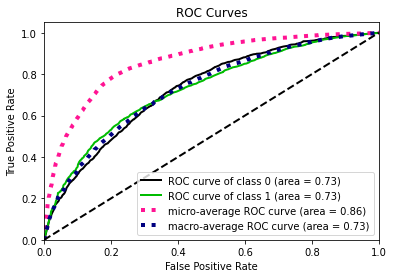


Feature Importances : {'year': 0.47, 'geo_dist': 0.27, 'depth (km)': 0.19, 'month': 0.06}


In [31]:
dtree = DecisionTreeClassifier(min_samples_split=250)
dtree.fit(Xs_train, Y_train)
Yts_pred = dtree.predict(Xs_test)
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Yts_pred, target_names=target_names))
print("ROC AUC score:",roc_auc_score(Y_test, dtree.predict_proba(Xs_test)[:,1]))
Yts_prob = dtree.predict_proba(Xs_test)
skplt.metrics.plot_roc_curve(Y_test, Yts_prob)
plt.show()
feature_importances = [round(f,2) for f in dtree.feature_importances_]
feature_importances = dict(zip(df_data_org.drop(['mw'], axis=1).columns,feature_importances))
feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))
print("\nFeature Importances :",feature_importances)

####As we can see, there is no difference between the performance of decision tree classifier with or without standardization.  
####The most important features obtained by decision trees are : **1) Year and 2) GeoDist (Lat / Long)**

#**MLP Classifier**  
We use standardized data for MLP classification because if one feature is ranging from 0 to 0.1 and other features range from 1-1000 the MLP can give more importance to certain features. Also, data standardization generally speeds up learning and leads to faster convergence.

              precision    recall  f1-score   support

     class 0       0.65      0.09      0.15      2205
     class 1       0.79      0.99      0.88      7891

    accuracy                           0.79     10096
   macro avg       0.72      0.54      0.52     10096
weighted avg       0.76      0.79      0.72     10096

ROC AUC score: 0.7187171527251546


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


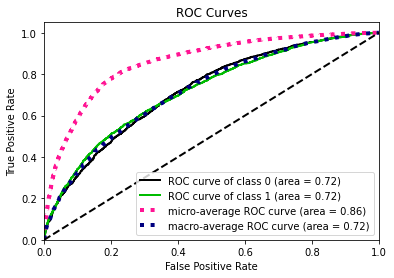

In [32]:
mlp = MLPClassifier(random_state=1, max_iter=1000, activation='relu', solver='adam')
mlp.fit(Xs_train, Y_train)
Ym_pred = mlp.predict(Xs_test)
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Ym_pred, target_names=target_names))
print("ROC AUC score:",roc_auc_score(Y_test, mlp.predict_proba(Xs_test)[:,1]))
Ym_prob = mlp.predict_proba(Xs_test)
skplt.metrics.plot_roc_curve(Y_test, Ym_prob)
plt.show()

####We observe that the 3 individual classification models (KNN, Decision Tree, MLP) result into same accuracy score (79%) but varying ROC-AUC score : **DTree (0.73) > MLP (0.72) > KNN (0.70)**  
####Here, Decision Tree performs the best and KNN performs the worst.

#**Ensemble Learning**  
  
The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator. Two families of ensemble methods are usually distinguished:  


*   **Averaging Methods** : The driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced.
*   **Boosting Methods** : Base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble.



##**Random Forest Classifier**  
A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. Individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. Random forests achieve a reduced variance by combining diverse trees.

              precision    recall  f1-score   support

     class 0       0.59      0.12      0.20      2144
     class 1       0.80      0.98      0.88      7952

    accuracy                           0.80     10096
   macro avg       0.70      0.55      0.54     10096
weighted avg       0.76      0.80      0.74     10096

ROC AUC score: 0.746038468450629


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


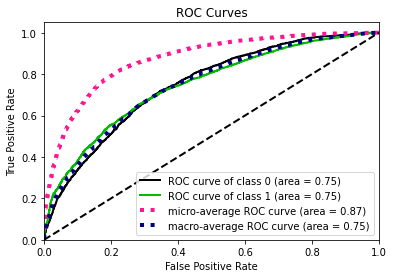


Feature Importances : {'year': 0.5, 'geo_dist': 0.24, 'depth (km)': 0.19, 'month': 0.07}


In [33]:
forest = RandomForestClassifier(n_estimators=10, min_samples_split=250, random_state=1)
forest.fit(Xt_train, Yt_train)
Yt_pred = forest.predict(Xt_test)
target_names = ['class 0', 'class 1']
print(classification_report(Yt_test, Yt_pred, target_names=target_names))
print("ROC AUC score:",roc_auc_score(Yt_test, forest.predict_proba(Xt_test)[:,1]))
Yt_prob = forest.predict_proba(Xt_test)
skplt.metrics.plot_roc_curve(Yt_test, Yt_prob)
plt.show()
feature_importances = [round(f,2) for f in forest.feature_importances_]
feature_importances = dict(zip(df_data_org.drop(['mw'], axis=1).columns,feature_importances))
feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))
print("\nFeature Importances :",feature_importances)

####We observe that Random Forest has obtained much better improvememt of ROC-AUC score of 0.75 over the individual models.  
####Random Forest also gives the same important features (year and geo_dist) as given by Decision Tree.

##**AdaBoost Classifier**  
The core principle of AdaBoost is to fit a sequence of weak learners on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. The data modifications at each so-called boosting iteration consist of applying different weights to each of the training samples. At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence.

###Tuning Hyperparameter No. of Estimators

In [34]:
for e in [10,50,100,250,500,1000]:
    ada = AdaBoostClassifier(n_estimators=e, random_state=1, base_estimator=None)
    ada.fit(Xs_train, Y_train)
    Ya_pred = ada.predict(Xs_test)
    target_names = ['class 0', 'class 1']
    print("***** No. of estimators :",e,"*****")
    print(classification_report(Y_test, Ya_pred, target_names=target_names))
    print("ROC AUC score:",roc_auc_score(Y_test, ada.decision_function(Xs_test), average='weighted'))
    print("\n")

***** No. of estimators : 10 *****
              precision    recall  f1-score   support

     class 0       0.56      0.08      0.14      2205
     class 1       0.79      0.98      0.88      7891

    accuracy                           0.79     10096
   macro avg       0.68      0.53      0.51     10096
weighted avg       0.74      0.79      0.72     10096

ROC AUC score: 0.6875290343400488


***** No. of estimators : 50 *****
              precision    recall  f1-score   support

     class 0       0.57      0.08      0.14      2205
     class 1       0.79      0.98      0.88      7891

    accuracy                           0.79     10096
   macro avg       0.68      0.53      0.51     10096
weighted avg       0.74      0.79      0.72     10096

ROC AUC score: 0.713567050611061


***** No. of estimators : 100 *****
              precision    recall  f1-score   support

     class 0       0.58      0.09      0.15      2205
     class 1       0.79      0.98      0.88      7891

    a

###Best ROC-AUC Score Obtained by No. of Estimators=500
###Using Standardized data

              precision    recall  f1-score   support

     class 0       0.58      0.09      0.15      2205
     class 1       0.79      0.98      0.88      7891

    accuracy                           0.79     10096
   macro avg       0.69      0.54      0.52     10096
weighted avg       0.75      0.79      0.72     10096

ROC AUC score: 0.7233820728054665


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


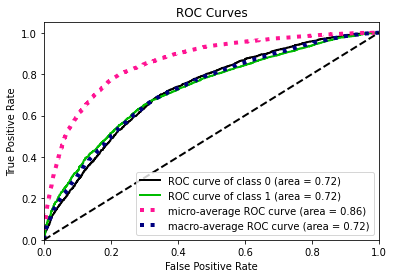


Feature Importances : {'geo_dist': 0.38, 'year': 0.36, 'depth (km)': 0.24, 'month': 0.02}


In [35]:
ada = AdaBoostClassifier(n_estimators=500, random_state=1, base_estimator=None)
ada.fit(Xs_train, Y_train)
Ya_pred = ada.predict(Xs_test)
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Ya_pred, target_names=target_names))
print("ROC AUC score:",roc_auc_score(Y_test, ada.decision_function(Xs_test), average='weighted'))
Ya_prob = ada.predict_proba(Xs_test)
skplt.metrics.plot_roc_curve(Y_test, Ya_prob)
plt.show()
feature_importances = [round(f,2) for f in ada.feature_importances_]
feature_importances = dict(zip(df_data_org.drop(['mw'], axis=1).columns,feature_importances))
feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))
print("\nFeature Importances :",feature_importances)

####We observe that AdaBoost performs better than KNN and MLP but not better than Decision Tree and Random Forest.

##**Voting Classifier**  
The idea behind the VotingClassifier is to combine conceptually different machine learning classifiers and use a majority vote or the average predicted probabilities (soft vote) to predict the class labels. Such a classifier can be useful for a set of equally well performing model in order to balance out their individual weaknesses.



              precision    recall  f1-score   support

     class 0       0.60      0.12      0.21      2205
     class 1       0.80      0.98      0.88      7891

    accuracy                           0.79     10096
   macro avg       0.70      0.55      0.54     10096
weighted avg       0.76      0.79      0.73     10096

ROC AUC score: 0.737422638552316


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


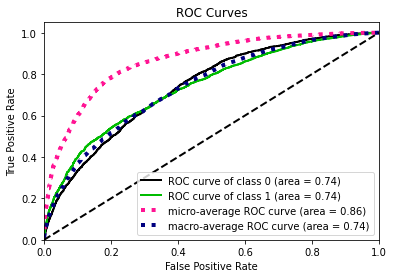

In [37]:
clf1 = KNeighborsClassifier(n_neighbors=25, weights='distance')
clf2 = DecisionTreeClassifier(min_samples_split=250)
clf3 = MLPClassifier(random_state=1, max_iter=1000, activation='relu', solver='adam')

voter = VotingClassifier(estimators=[('knn', clf1), ('dt', clf2), ('mlp', clf3)], voting='soft')
voter.fit(Xs_train, Y_train)
Yv_pred = voter.predict(Xs_test)
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Yv_pred, target_names=target_names))
print("ROC AUC score:",roc_auc_score(Y_test, voter.predict_proba(Xs_test)[:,1]))
Yv_prob = voter.predict_proba(Xs_test)
skplt.metrics.plot_roc_curve(Y_test, Yv_prob)
plt.show()

##**Stacking Classifier**  
Stacked generalization consists of stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator. The estimators are stacked together in parallel on the input data. The final estimator (Logistic Regressor by default) will use the predictions of the estimators as input.

              precision    recall  f1-score   support

     class 0       0.60      0.15      0.24      2205
     class 1       0.80      0.97      0.88      7891

    accuracy                           0.79     10096
   macro avg       0.70      0.56      0.56     10096
weighted avg       0.76      0.79      0.74     10096

ROC AUC score: 0.7403367193200096


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


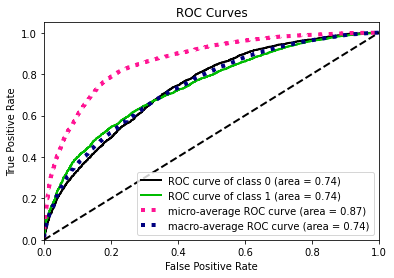

In [38]:
clf1 = KNeighborsClassifier(n_neighbors=25, weights='distance')
clf2 = DecisionTreeClassifier(min_samples_split=250)
clf3 = MLPClassifier(random_state=1, max_iter=1000, activation='relu', solver='adam')
## final estimator is logistic regressor by default
stk = StackingClassifier(estimators=[('knn', clf1), ('dt', clf2), ('mlp', clf3)])
stk.fit(Xs_train, Y_train)
Yk_pred = stk.predict(Xs_test)
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Yk_pred, target_names=target_names))
print("ROC AUC score:",roc_auc_score(Y_test, stk.decision_function(Xs_test), average='weighted'))
Yk_prob = stk.predict_proba(Xs_test)
skplt.metrics.plot_roc_curve(Y_test, Yk_prob)
plt.show()

####As we can see, stacking classifier outperforms all the above classifiers except (but similar to) Random Forest.

##**Bagging Classifier**  
A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.

              precision    recall  f1-score   support

     class 0       0.64      0.13      0.21      2205
     class 1       0.80      0.98      0.88      7891

    accuracy                           0.79     10096
   macro avg       0.72      0.55      0.55     10096
weighted avg       0.77      0.79      0.73     10096

ROC AUC score: 0.7473368581158649


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


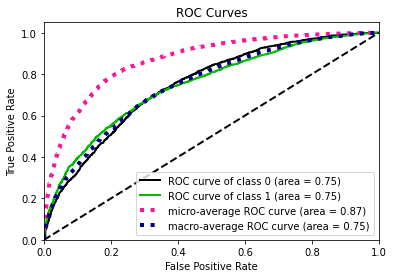

In [10]:
bg = BaggingClassifier(DecisionTreeClassifier(min_samples_split=250), max_samples=0.5, random_state=1)
bg.fit(Xs_train, Y_train)
Yb_pred = bg.predict(Xs_test)
target_names = ['class 0', 'class 1']
print(classification_report(Y_test, Yb_pred, target_names=target_names))
print("ROC AUC score:",roc_auc_score(Y_test, bg.predict_proba(Xs_test)[:,1], average='weighted'))
Yb_prob = bg.predict_proba(Xs_test)
skplt.metrics.plot_roc_curve(Y_test, Yb_prob)
plt.show()

####We Observe that Bagging Classifier outperforms all other models.  
####Ensemble Learning model performances (wrt ROC-AUC scores) are : **Bagging (0.75) > RandomForest (0.75) > Stacking (0.74) > Voting (0.73) > AdaBoost (0.72)**  
####In general, ensemble methods perform better than individual models but relatively Bagging classifier performs the best and AdaBoost the worst.

#**Classification Using 2 Most Important Features**  
We had obtained Year and GeoDist as important features. Thus, we remove all other features except these and then standardize them.

In [11]:
df_Ximp = df_data_org[['year','geo_dist']].copy()
Ximp = df_Ximp.values
Yimp = df_data_org.mw.values
print(Ximp.shape)
print(Yimp.shape)

scaler = StandardScaler()
Ximp_scaled = scaler.fit_transform(Ximp)
print("Total",Counter(Y))

Ximps_train, Ximps_test, Yimp_train, Yimp_test = train_test_split(Ximp_scaled, Yimp, test_size=0.20, random_state=1, stratify=Yimp)
print("Train",Counter(Yimp_train))
print("Test",Counter(Yimp_test))

(50480, 2)
(50480,)
Total Counter({1: 39759, 0: 10721})
Train Counter({1: 31807, 0: 8577})
Test Counter({1: 7952, 0: 2144})


##Random Forest Classifier

              precision    recall  f1-score   support

     class 0       0.64      0.11      0.18      2144
     class 1       0.80      0.98      0.88      7952

    accuracy                           0.80     10096
   macro avg       0.72      0.54      0.53     10096
weighted avg       0.77      0.80      0.74     10096

ROC AUC score: 0.7136457973587795


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


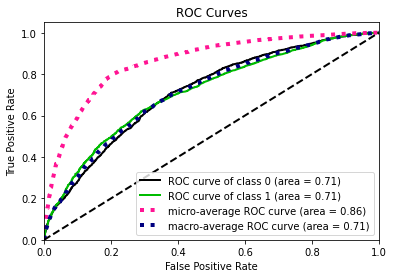


Feature Importances : {'year': 0.59, 'geo_dist': 0.41}


In [40]:
forest = RandomForestClassifier(n_estimators=10, min_samples_split=250, random_state=1)
forest.fit(Ximps_train, Yimp_train)
Yt_pred = forest.predict(Ximps_test)
target_names = ['class 0', 'class 1']
print(classification_report(Yimp_test, Yt_pred, target_names=target_names))
print("ROC AUC score:",roc_auc_score(Yimp_test, forest.predict_proba(Ximps_test)[:,1]))
Yt_prob = forest.predict_proba(Ximps_test)
skplt.metrics.plot_roc_curve(Yimp_test, Yt_prob)
plt.show()
feature_importances = [round(f,2) for f in forest.feature_importances_]
feature_importances = dict(zip(df_Ximp.columns,feature_importances))
feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))
print("\nFeature Importances :",feature_importances)

##AdaBoost Classifier

              precision    recall  f1-score   support

     class 0       0.62      0.08      0.14      2144
     class 1       0.80      0.99      0.88      7952

    accuracy                           0.79     10096
   macro avg       0.71      0.53      0.51     10096
weighted avg       0.76      0.79      0.73     10096

ROC AUC score: 0.6992703070099703


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


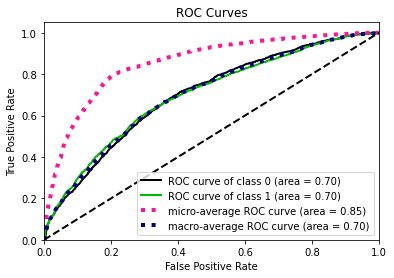


Feature Importances : {'geo_dist': 0.62, 'year': 0.38}


In [41]:
ada = AdaBoostClassifier(n_estimators=500, random_state=1, base_estimator=None)
ada.fit(Ximps_train, Yimp_train)
Ya_pred = ada.predict(Ximps_test)
target_names = ['class 0', 'class 1']
print(classification_report(Yimp_test, Ya_pred, target_names=target_names))
print("ROC AUC score:",roc_auc_score(Yimp_test, ada.decision_function(Ximps_test), average='weighted'))
Ya_prob = ada.predict_proba(Ximps_test)
skplt.metrics.plot_roc_curve(Yimp_test, Ya_prob)
plt.show()
feature_importances = [round(f,2) for f in ada.feature_importances_]
feature_importances = dict(zip(df_Ximp.columns,feature_importances))
feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))
print("\nFeature Importances :",feature_importances)

##Voting Classifier

              precision    recall  f1-score   support

     class 0       0.49      0.14      0.21      2144
     class 1       0.81      0.96      0.88      7952

    accuracy                           0.79     10096
   macro avg       0.65      0.55      0.54     10096
weighted avg       0.74      0.79      0.74     10096

ROC AUC score: 0.6999075844995345


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


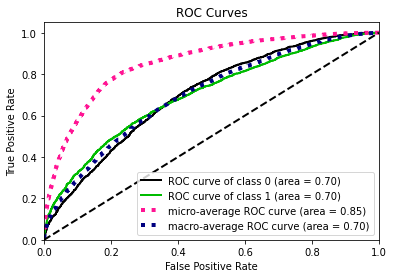

In [42]:
clf1 = KNeighborsClassifier(n_neighbors=25, weights='distance')
clf2 = DecisionTreeClassifier(min_samples_split=250)
clf3 = MLPClassifier(random_state=1, max_iter=1000, activation='relu', solver='adam')

voter = VotingClassifier(estimators=[('knn', clf1), ('dt', clf2), ('mlp', clf3)], voting='soft')
voter.fit(Ximps_train, Yimp_train)
Yv_pred = voter.predict(Ximps_test)
target_names = ['class 0', 'class 1']
print(classification_report(Yimp_test, Yv_pred, target_names=target_names))
print("ROC AUC score:",roc_auc_score(Yimp_test, voter.predict_proba(Ximps_test)[:,1]))
Yv_prob = voter.predict_proba(Ximps_test)
skplt.metrics.plot_roc_curve(Yimp_test, Yv_prob)
plt.show()

##Stacking Classifier

              precision    recall  f1-score   support

     class 0       0.60      0.10      0.17      2144
     class 1       0.80      0.98      0.88      7952

    accuracy                           0.79     10096
   macro avg       0.70      0.54      0.53     10096
weighted avg       0.76      0.79      0.73     10096

ROC AUC score: 0.7072777147962402


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


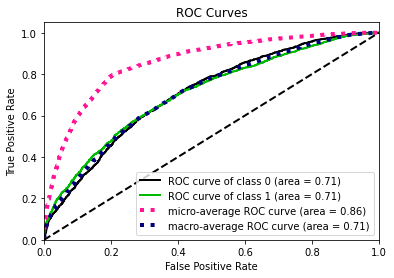

In [43]:
clf1 = KNeighborsClassifier(n_neighbors=25, weights='distance')
clf2 = DecisionTreeClassifier(min_samples_split=250)
clf3 = MLPClassifier(random_state=1, max_iter=1000, activation='relu', solver='adam')

stk = StackingClassifier(estimators=[('knn', clf1), ('dt', clf2), ('mlp', clf3)])
stk.fit(Ximps_train, Yimp_train)
Yk_pred = stk.predict(Ximps_test)
target_names = ['class 0', 'class 1']
print(classification_report(Yimp_test, Yk_pred, target_names=target_names))
print("ROC AUC score:",roc_auc_score(Yimp_test, stk.decision_function(Ximps_test), average='weighted'))
Yk_prob = stk.predict_proba(Ximps_test)
skplt.metrics.plot_roc_curve(Yimp_test, Yk_prob)
plt.show()

##Bagging Classifier

              precision    recall  f1-score   support

     class 0       0.61      0.11      0.19      2144
     class 1       0.80      0.98      0.88      7952

    accuracy                           0.80     10096
   macro avg       0.71      0.55      0.54     10096
weighted avg       0.76      0.80      0.74     10096

ROC AUC score: 0.7074118861959069


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


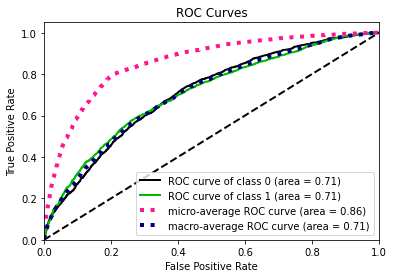

In [12]:
bg = BaggingClassifier(DecisionTreeClassifier(min_samples_split=250), max_samples=0.5, random_state=1)
bg.fit(Ximps_train, Yimp_train)
Yb_pred = bg.predict(Ximps_test)
target_names = ['class 0', 'class 1']
print(classification_report(Yimp_test, Yb_pred, target_names=target_names))
print("ROC AUC score:",roc_auc_score(Yimp_test, bg.predict_proba(Ximps_test)[:,1], average='weighted'))
Yb_prob = bg.predict_proba(Ximps_test)
skplt.metrics.plot_roc_curve(Yimp_test, Yb_prob)
plt.show()

####We observe the performance of all the ensemble methods has degraded a little (0.02 to 0.03 decrease in ROC-AUC score) after considering only 2 important features and removing others. But we can say that these 2 features provide good cue for classification.